# EDA of the tweets of realDonaldTrump

So the summary that I have currently is that 

* you really need to use as much recent data as possible, even the last year of data is turrible.
* Need to adjust for hours
* Need to adjust for days of the week

In [314]:
import json
from pathlib import Path
import sys
from collections import Counter
import datetime

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, skew, skewnorm, describe, gengamma, rv_continuous, gamma, gaussian_kde


In [228]:
#!{sys.executable} -m pip install matplotlib

## Read them in and turn into DataFrame

okay there is the json, but there is the more accurate csv

In [229]:
tweet_path = Path("../data/realDonaldTrump.json")
tweet_path.exists()

True

In [230]:
tweet_dict = dict()

with open(tweet_path, 'r') as read_file:
    for thing in read_file:
        tweet_json = json.loads(thing)
        
        # combine time and date
        date_time = tweet_json["date"] + " " + tweet_json["time"]
        time_zone = tweet_json['timezone']
        
        tweet_dict[date_time] = tweet_json["id"]

In [231]:
date_time

'2017-01-01 06:00:10'

In [232]:
json.loads(thing)

{'id': 815422340540547073,
 'conversation_id': '815422340540547073',
 'created_at': 1483246810000,
 'date': '2017-01-01',
 'time': '06:00:10',
 'timezone': 'CEST',
 'user_id': 25073877,
 'username': 'realdonaldtrump',
 'name': 'Donald J. Trump',
 'place': '',
 'tweet': 'TO ALL AMERICANS-\n#HappyNewYear & many blessings to you all! Looking forward to a wonderful & prosperous 2017 as we work together to #MAGA🇺🇸 pic.twitter.com/UaBFaoDYHe',
 'mentions': [],
 'urls': [],
 'photos': ['https://pbs.twimg.com/media/C1D2SsLVEAIn1UJ.jpg'],
 'replies_count': 19020,
 'retweets_count': 27943,
 'likes_count': 112710,
 'hashtags': ['#happynewyear', '#maga'],
 'cashtags': [],
 'link': 'https://twitter.com/realDonaldTrump/status/815422340540547073',
 'retweet': False,
 'quote_url': '',
 'video': 0,
 'near': '',
 'geo': '',
 'source': '',
 'user_rt_id': '',
 'user_rt': '',
 'retweet_id': '',
 'reply_to': [{'user_id': '25073877', 'username': 'realDonaldTrump'}],
 'retweet_date': '',
 'translate': '',
 't

In [233]:
df = pd.DataFrame.from_dict(tweet_dict, orient='index', columns=['ID'])

In [234]:
df.index = pd.to_datetime(df.index)

## CSV

In [235]:
tweet_path = Path("../data/realDonaldTrump.csv")
tweet_path.exists()

True

In [236]:
df = pd.read_csv(tweet_path)


df.index = pd.to_datetime(df['created_at'])

df = pd.DataFrame(df['id_str'])

df.columns = ['ID']

df.head()

,ID
created_at,
2020-04-28 20:24:20,1255231394923646976
2020-04-28 20:14:31,1255228926428942339
2020-04-28 20:13:47,1255228739027456001
2020-04-28 14:43:53,1255145720136359945
2020-04-28 14:04:50,1255135893557403648


## Quantitative description

### Per day, just in general

In [237]:
by_day = df.groupby(df.index.date).count()
by_day["ID"].mean()

14.564529558701082

In [238]:
by_day["ID"].std()

13.730539227066087

In [239]:
daily_count = pd.DataFrame.from_dict(Counter(by_day["ID"]), orient='index', columns=['count']).sort_index()

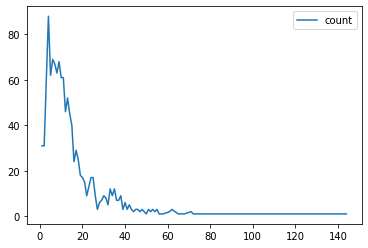

In [240]:
daily_count.plot()

In [241]:
daily_count['probability'] = daily_count['count'] / daily_count['count'].sum()

In [242]:
daily_count.head()

,count,probability
1,31,0.025812
2,31,0.025812
3,60,0.049958
4,88,0.073272
5,62,0.051624


### By Day of Week

Monday = 0

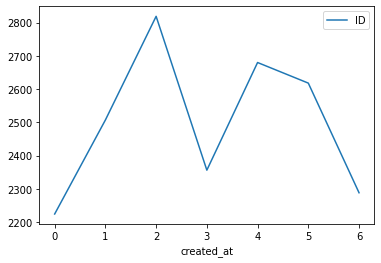

In [243]:
day_of_week = df.groupby(df.index.dayofweek).count()

day_of_week.plot()

## By Hour

Honestly, he probably does sleep for 4 hours a night

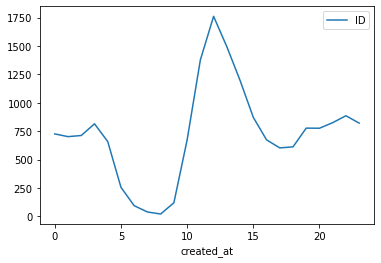

In [244]:
by_hour = df.groupby(df.index.hour).count()
by_hour.plot()

## A priori weekly odds

tl;dr we just see what the odds are of each of the buckets at the start of each week

In [245]:
by_day["sum_7"] = by_day.rolling(window=7).sum()

In [246]:
prior_counts = {
  "149" : sum(by_day["sum_7"] <= 149),
  "150-159" : sum((by_day["sum_7"] >= 150) & (by_day["sum_7"] < 160)),
  "160-169" : sum((by_day["sum_7"] >= 160) & (by_day["sum_7"] < 170)),
  "170-179" : sum((by_day["sum_7"] >= 170) & (by_day["sum_7"] < 180)),
  "180-189" : sum((by_day["sum_7"] >= 180) & (by_day["sum_7"] < 190)),
  "190-199" : sum((by_day["sum_7"] >= 190) & (by_day["sum_7"] < 200)),
  "200-209" : sum((by_day["sum_7"] >= 200) & (by_day["sum_7"] < 210)),
  "210-219" : sum((by_day["sum_7"] >= 210) & (by_day["sum_7"] < 219)),
  "220" : sum(by_day["sum_7"] >= 220)
}


In [247]:
prior_counts

{'149': 929,
 '150-159': 29,
 '160-169': 19,
 '170-179': 23,
 '180-189': 32,
 '190-199': 18,
 '200-209': 29,
 '210-219': 16,
 '220': 98}

## That <149 number is awfully suss

Let's investigate

In [248]:
#df.groupby(df.index.hour).count()
weekly_lt_149 = by_day[by_day["sum_7"] <= 149]
weekly_lt_149.index = pd.to_datetime(weekly_lt_149.index)

weekly_lt_149.groupby(weekly_lt_149.index.year).count()

,ID,sum_7
2017,357,357
2018,355,355
2019,205,205
2020,12,12


In [249]:
bday = by_day.drop(['sum_7'], axis=1)

In [250]:
# GB=DF.groupby([(DF.index.year),(DF.index.month)]).sum()
bday.index = pd.to_datetime(bday.index)
bmonth = bday.groupby([(bday.index.year), (bday.index.month)]).sum()
bmonth

ID
2017 1    214
     2    154
     3    147
     4    152
     5    155
     6    212
     7    242
     8    267
     9    306
     10   290
     11   261
     12   199
2018 1    205
     2    175
     3    171
     4    257
     5    259
     6    309
     7    336
     8    380
     9    383
     10   384
     11   338
     12   294
2019 1    369
     2    249
     3    405
     4    431
     5    692
     6    487
     7    692
     8    690
     9    797
     10  1018
     11   862
     12  1126
2020 1    964
     2    898
     3    971
     4    751

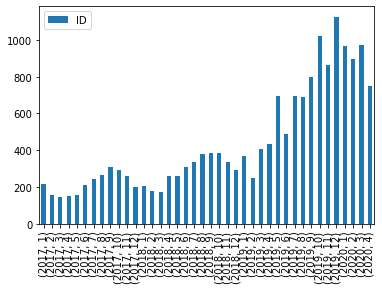

In [251]:
bmonth.plot.bar()

### Using the last year of data

Yeah clearly we're drawingc from a different distribution since May-July of last year, so let's just use the last year of data as our prior

In [252]:
df_s = df[:df.iloc[0].name - datetime.timedelta(days=365)]

In [253]:
by_day = df_s.groupby(df_s.index.date).count()
by_day["ID"].mean()

27.215846994535518

In [254]:
by_day["ID"].std()

17.73595899114083

In [255]:
daily_count = pd.DataFrame.from_dict(Counter(by_day["ID"]), orient='index', columns=['count']).sort_index()

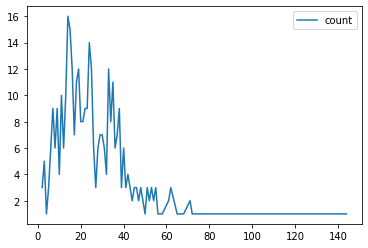

In [256]:
daily_count.plot()

In [257]:
daily_count['probability'] = daily_count['count'] / daily_count['count'].sum()

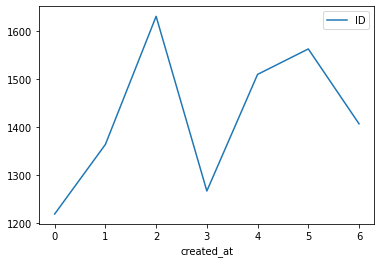

In [258]:
day_of_week = df_s.groupby(df_s.index.dayofweek).count()

day_of_week.plot()

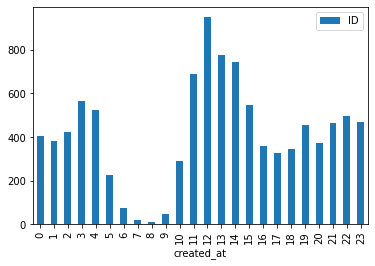

In [259]:
by_hour = df_s.groupby(df_s.index.hour).count()
by_hour.plot.bar()

In [260]:
by_day["sum_7"] = by_day.rolling(window=7).sum()

In [261]:
prior_counts = {
  "149" : sum(by_day["sum_7"] <= 149),
  "150-159" : sum((by_day["sum_7"] >= 150) & (by_day["sum_7"] < 160)),
  "160-169" : sum((by_day["sum_7"] >= 160) & (by_day["sum_7"] < 170)),
  "170-179" : sum((by_day["sum_7"] >= 170) & (by_day["sum_7"] < 180)),
  "180-189" : sum((by_day["sum_7"] >= 180) & (by_day["sum_7"] < 190)),
  "190-199" : sum((by_day["sum_7"] >= 190) & (by_day["sum_7"] < 200)),
  "200-209" : sum((by_day["sum_7"] >= 200) & (by_day["sum_7"] < 210)),
  "210-219" : sum((by_day["sum_7"] >= 210) & (by_day["sum_7"] < 219)),
  "220" : sum(by_day["sum_7"] >= 220)
}


In [262]:
weeklies = pd.DataFrame.from_dict(prior_counts, orient='index', columns=["Counts"])

In [263]:
weeklies["Counts"] / weeklies["Counts"].sum()

149        0.268156
150-159    0.078212
160-169    0.050279
170-179    0.067039
180-189    0.086592
190-199    0.050279
200-209    0.081006
210-219    0.044693
220        0.273743
Name: Counts, dtype: float64

### Same distribution

Is the past month the same distribution as the previous 90 days?

`df_s = df[:df.iloc[0].name - datetime.timedelta(days=365)]`

In [264]:
describe(by_day_year["ID"])

DescribeResult(nobs=366, minmax=(2, 144), mean=27.215846994535518, variance=314.56424133542924, skewness=1.8300564835968227, kurtosis=6.594014303660439)

In [265]:
by_day_year = by_day[by_day.iloc[0].name - datetime.timedelta(days=365):]

In [266]:
skewness = skew(by_day_year["ID"])

In [267]:
y_max = max(by_day_year["ID"])
y_max = 48
num = len(by_day_year["ID"])

In [268]:

random = skewnorm.rvs(a = skewness*-1, loc=75, size=num)
random = random - min(random)
random = random / max(random)
random = random * y_max

In [269]:
random.round().sum()

9645.0

In [270]:
by_day_year["ID"].sum()

9961

In [271]:
Counter(random.round())

Counter({30.0: 24,
         34.0: 10,
         37.0: 8,
         39.0: 12,
         27.0: 23,
         35.0: 14,
         12.0: 7,
         26.0: 14,
         20.0: 15,
         16.0: 9,
         29.0: 10,
         41.0: 8,
         28.0: 17,
         14.0: 10,
         42.0: 3,
         33.0: 12,
         40.0: 2,
         22.0: 7,
         32.0: 17,
         24.0: 17,
         17.0: 6,
         25.0: 17,
         8.0: 3,
         3.0: 2,
         15.0: 7,
         31.0: 16,
         10.0: 1,
         21.0: 12,
         5.0: 1,
         9.0: 2,
         2.0: 1,
         19.0: 7,
         23.0: 18,
         11.0: 2,
         18.0: 8,
         7.0: 1,
         6.0: 1,
         13.0: 3,
         43.0: 1,
         4.0: 1,
         38.0: 7,
         0.0: 1,
         36.0: 6,
         48.0: 1,
         44.0: 1,
         45.0: 1})

The generalized gamma function has non-zero skew and kurtosis, but you'll have a little work to do to figure out what parameters to use to specify the distribution to get a particular mean, variance, skew and kurtosis. Here's some code to get you started.

```
import scipy.stats
import matplotlib.pyplot as plt
distribution = scipy.stats.norm(loc=100,scale=5)
sample = distribution.rvs(size=10000)
plt.hist(sample)
plt.show()
print distribution.stats('mvsk')
```

This displays a histogram of a 10,000 element sample from a normal distribution with mean 100 and variance 25, and prints the distribution's statistics:

`(array(100.0), array(25.0), array(0.0), array(0.0))`

Replacing the normal distribution with the generalized gamma distribution,

`distribution = scipy.stats.gengamma(100, 70, loc=50, scale=10)`

you get the statistics `[mean, variance, skew, kurtosis] (array(60.67925117494595), array(0.00023388203873597746), array(-0.09588807605341435), array(-0.028177799805207737)).`

==

```
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
>>> ax.legend(loc='best', frameon=False)
>>> plt.show()
```

(array(29.39283328), array(368.6428932), array(1.51154415), array(3.84704774))


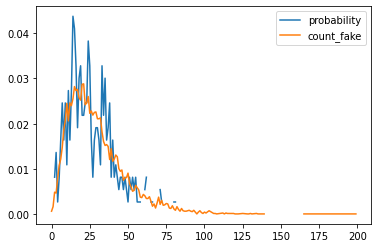

In [325]:
k=7.5
w=0.6
loc=-1.75
scale=1.01

rv = gengamma(k,w,loc=loc,scale=scale)

print(rv.stats(moments="mvsk"))

r = rv.rvs(size=10000)

#plt.hist(r)


r.round().astype(int)

fake = pd.DataFrame.from_dict(Counter(r.round().astype(int)), orient='index', columns=['count_fake']).sort_index()

fake["count_fake"] = fake["count_fake"]/fake["count_fake"].sum()

pd.concat([daily_count['probability'], fake], axis=1).plot()

rv_continuous.fit(gamma, x, floc=0, fscale=4)

rv_continuous.fit(gengamma, daily_count["count"])

In [324]:
gengamma.fit(by_day["ID"])

(7.501038683060314, 0.6135314520114181, -1.7527166146437148, 1.016664248133961)

## Gaussian Kernel Estimation

```
from scipy.stats import gaussian_kde
occurences = [0,0,0,0,..,1,1,1,1,...,2,2,2,2,...,47]
values = range(0,48)
kde = gaussian_kde(map(float, occurences))
p = kde(values)
p = p/sum(p)
print "P(x>=1) = %f" % sum(p[1:])
```

In [366]:
kde = gaussian_kde(by_day["ID"])

In [368]:
by_day["ID"].max()

144

In [322]:
daily_count["count"]

2      3
3      5
4      1
5      3
6      6
      ..
81     1
87     1
97     1
112    1
144    1
Name: count, Length: 71, dtype: int64

## Okay let's just see what the differences are 

In [326]:
ninety_days = by_day.iloc[len(by_day)-1].name - datetime.timedelta(days=90)
thirty_days = by_day.iloc[len(by_day)-1].name - datetime.timedelta(days=30)

In [327]:
df_30 = by_day[thirty_days:]
df_90 = by_day[ninety_days:thirty_days]

In [346]:
def make_pd(data):
    k, v, loc, scale = gengamma.fit(data)
    rv = gengamma(k,v,loc=loc,scale=scale)
    print(rv.stats(moments="mvsk"))
    r = rv.rvs(size=10000)
    
    fake = pd.DataFrame.from_dict(Counter(r.round().astype(int)), orient='index', columns=['count_fake']).sort_index()
    fake["count_fake"] = fake["count_fake"]/fake["count_fake"].sum()
    
    return fake

In [359]:
def make_n_pd(data):
    fake = pd.DataFrame.from_dict(Counter(data), orient='index', columns=['count_real']).sort_index()
    fake["count_real"] = fake["count_real"]/fake["count_real"].sum()
    return fake

In [349]:
a = make_pd(df_30["ID"])
a.columns = ["dist_30"]

(array(26.61343438), array(284.23536524), array(1.90762173), array(6.58379913))


In [351]:
b = make_pd(df_90["ID"])
b.columns = ['dist_90']

(array(31.60045533), array(298.88056027), array(0.84418959), array(1.06414177))


In [361]:
a_1 = make_n_pd(df_30["ID"])
a_1.columns = ['real_dist_30']

In [364]:
b_1 = make_n_pd(df_90["ID"])
b_1.columns = ['real_dist_90']

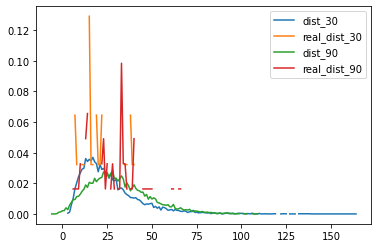

In [365]:
pd.concat([a, a_1, b, b_1], axis=1).plot()

In [332]:
k, v, loc, scale = gengamma.fit(df_30["ID"])

(19.060838464931628,
 0.35240502826945086,
 1.7124332977360788,
 0.00508767032048334)

In [334]:
k, v, loc, scale = gengamma.fit(df_90["ID"])